# Libraries

In [ ]:
import os
import random, numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

# Data Processing + Dataset Loading

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys

!find /content/drive/MyDrive -name "comments_labeled.csv"

Mounted at /content/drive
/content/drive/MyDrive/대학원/딥러닝/딥러닝 프로젝트/multilabel.csv
/content/drive/MyDrive/multilabel.csv


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/comments_labeled.csv")

In [ ]:
texts = df["comments"].tolist()
label_cols = ["gender", "age", "appearance", "individual/group", "cleanness"]
labels = df[label_cols].values.tolist()
df

<Axes: >

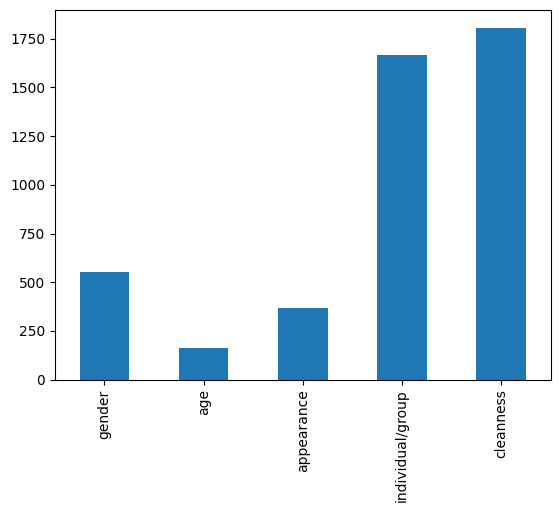

In [ ]:
df[label_cols].sum().plot(kind='bar')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

In [ ]:
# Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        super().__init__()
        self.texts      = texts
        self.labels     = labels
        self.tokenizer  = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids':      encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label':          torch.tensor(label, dtype=torch.float)
        }

In [ ]:
# train(70%), val(20%), test(10%)
set_seed(seed)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=seed, shuffle=True
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=1/3, random_state=seed, shuffle=True
)

train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer, max_length=128)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, max_length=128)
test_dataset = HateSpeechDataset(test_texts, test_labels, tokenizer, max_length=128)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Define Model

In [ ]:
class HateSpeechClassifier(nn.Module):
    def __init__(self, hidden_dims=(512, 256), n_classes=5, dropout_rate=0.3):
        super(HateSpeechClassifier, self).__init__()
        self.kobert = AutoModel.from_pretrained("skt/kobert-base-v1")

        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(self.kobert.config.hidden_size, hidden_dims[0])
        self.relu1 = nn.ReLU()
        self.ln1 = nn.LayerNorm(hidden_dims[0])

        self.linear2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.relu2 = nn.ReLU()
        self.ln2 = nn.LayerNorm(hidden_dims[1])

        self.linear3 = nn.Linear(hidden_dims[1], n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.kobert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0]

        x = self.dropout(pooled_output)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.ln1(x)

        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.ln2(x)

        x = self.dropout(x)
        logits = self.linear3(x)

        return logits

In [ ]:
set_seed(seed)
model = HateSpeechClassifier(n_classes=5)
model.to(device)

print(model)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

HateSpeechClassifier(
  (kobert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
def compute_label_weights(loader, num_labels):
    total_counts = torch.zeros(num_labels)
    for batch in loader:
        labels = batch['label']
        total_counts += labels.sum(dim=0)

    total_samples = len(loader.dataset)
    pos_weights = total_samples / (total_counts + 1e-6)  # add epsilon to avoid divide by zero
    return pos_weights

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        # BCE with logits (no sigmoid here)
        bce_loss = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none', pos_weight=self.pos_weight
        )

        # Get the probabilities
        probas = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probas, 1 - probas)  # pt = p_t

        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss  # no reduction

def multi_label_accuracy(y_pred, y_true, threshold=0.5):
    y_pred_tag = (torch.sigmoid(y_pred) > threshold).float()
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum / torch.numel(y_true)
    return acc.item()

In [ ]:
# parameters
warmup_ratio = 0.1
num_epochs = 35
max_grad_norm = 1
log_interval = 200
learning_rate =  3e-5

# optimizer and loss function
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)

# schedule and accuracy function
t_total = len(train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
num_labels = 5

# compute label weights
raw_weights = compute_label_weights(train_loader, num_labels)
normalized_weights = raw_weights / raw_weights.sum() * num_labels
pos_weights = normalized_weights.to(device)

# create loss function with pos_weight
criterion = FocalLoss(alpha=1.0, gamma=2.0, pos_weight=pos_weights.to(device))

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

# Training and Validation

In [ ]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

start_time = time.time()

for e in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].long().to(device)
        attention_mask = batch['attention_mask'].long().to(device)
        labels = batch['label'].float().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_acc += multi_label_accuracy(outputs, labels)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)
    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(avg_train_acc)
    print(f"[Epoch {e+1}] Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].long().to(device)
            attention_mask = batch['attention_mask'].long().to(device)
            labels = batch['label'].float().to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += multi_label_accuracy(outputs, labels)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(avg_val_acc)
    print(f"[Epoch {e+1}] Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")

end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 1] Training Loss: 0.1270, Training Accuracy: 0.7085


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 1] Validation Loss: 0.1035, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 2] Training Loss: 0.1065, Training Accuracy: 0.7563


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 2] Validation Loss: 0.1028, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 3] Training Loss: 0.1022, Training Accuracy: 0.7587


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 3] Validation Loss: 0.0902, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 4] Training Loss: 0.1008, Training Accuracy: 0.7602


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 4] Validation Loss: 0.0881, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 5] Training Loss: 0.0968, Training Accuracy: 0.7675


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 5] Validation Loss: 0.0876, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 6] Training Loss: 0.0969, Training Accuracy: 0.7668


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 6] Validation Loss: 0.0859, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 7] Training Loss: 0.0950, Training Accuracy: 0.7680


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 7] Validation Loss: 0.0866, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 8] Training Loss: 0.0934, Training Accuracy: 0.7678


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 8] Validation Loss: 0.0860, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 9] Training Loss: 0.0925, Training Accuracy: 0.7695


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 9] Validation Loss: 0.0856, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 10] Training Loss: 0.0925, Training Accuracy: 0.7707


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 10] Validation Loss: 0.0862, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 11] Training Loss: 0.0903, Training Accuracy: 0.7714


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 11] Validation Loss: 0.0866, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 12] Training Loss: 0.0899, Training Accuracy: 0.7709


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 12] Validation Loss: 0.0861, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 13] Training Loss: 0.0889, Training Accuracy: 0.7708


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 13] Validation Loss: 0.0844, Validation Accuracy: 0.7713


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 14] Training Loss: 0.0860, Training Accuracy: 0.7717


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 14] Validation Loss: 0.0845, Validation Accuracy: 0.7718


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 15] Training Loss: 0.0867, Training Accuracy: 0.7718


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 15] Validation Loss: 0.0830, Validation Accuracy: 0.7720


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 16] Training Loss: 0.0848, Training Accuracy: 0.7739


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 16] Validation Loss: 0.0861, Validation Accuracy: 0.7710


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 17] Training Loss: 0.0833, Training Accuracy: 0.7741


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 17] Validation Loss: 0.0874, Validation Accuracy: 0.7723


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 18] Training Loss: 0.0816, Training Accuracy: 0.7747


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 18] Validation Loss: 0.0893, Validation Accuracy: 0.7753


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 19] Training Loss: 0.0793, Training Accuracy: 0.7763


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 19] Validation Loss: 0.0907, Validation Accuracy: 0.7640


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 20] Training Loss: 0.0781, Training Accuracy: 0.7742


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 20] Validation Loss: 0.0902, Validation Accuracy: 0.7703


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 21] Training Loss: 0.0749, Training Accuracy: 0.7744


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 21] Validation Loss: 0.0932, Validation Accuracy: 0.7698


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 22] Training Loss: 0.0730, Training Accuracy: 0.7790


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 22] Validation Loss: 0.0945, Validation Accuracy: 0.7683


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 23] Training Loss: 0.0701, Training Accuracy: 0.7808


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 23] Validation Loss: 0.1032, Validation Accuracy: 0.7618


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 24] Training Loss: 0.0683, Training Accuracy: 0.7822


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 24] Validation Loss: 0.1033, Validation Accuracy: 0.7695


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 25] Training Loss: 0.0658, Training Accuracy: 0.7843


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 25] Validation Loss: 0.1051, Validation Accuracy: 0.7675


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 26] Training Loss: 0.0646, Training Accuracy: 0.7852


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 26] Validation Loss: 0.1108, Validation Accuracy: 0.7693


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 27] Training Loss: 0.0633, Training Accuracy: 0.7862


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 27] Validation Loss: 0.1091, Validation Accuracy: 0.7648


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 28] Training Loss: 0.0605, Training Accuracy: 0.7896


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 28] Validation Loss: 0.1139, Validation Accuracy: 0.7658


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 29] Training Loss: 0.0597, Training Accuracy: 0.7917


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 29] Validation Loss: 0.1189, Validation Accuracy: 0.7618


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 30] Training Loss: 0.0580, Training Accuracy: 0.7939


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 30] Validation Loss: 0.1200, Validation Accuracy: 0.7668


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 31] Training Loss: 0.0576, Training Accuracy: 0.7958


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 31] Validation Loss: 0.1202, Validation Accuracy: 0.7615


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 32] Training Loss: 0.0562, Training Accuracy: 0.7995


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 32] Validation Loss: 0.1250, Validation Accuracy: 0.7618


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 33] Training Loss: 0.0564, Training Accuracy: 0.7977


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 33] Validation Loss: 0.1254, Validation Accuracy: 0.7625


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 34] Training Loss: 0.0554, Training Accuracy: 0.7986


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 34] Validation Loss: 0.1261, Validation Accuracy: 0.7628


  0%|          | 0/88 [00:00<?, ?it/s]

[Epoch 35] Training Loss: 0.0556, Training Accuracy: 0.8007


  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 35] Validation Loss: 0.1263, Validation Accuracy: 0.7630
Elapsed time: 2144.85 seconds


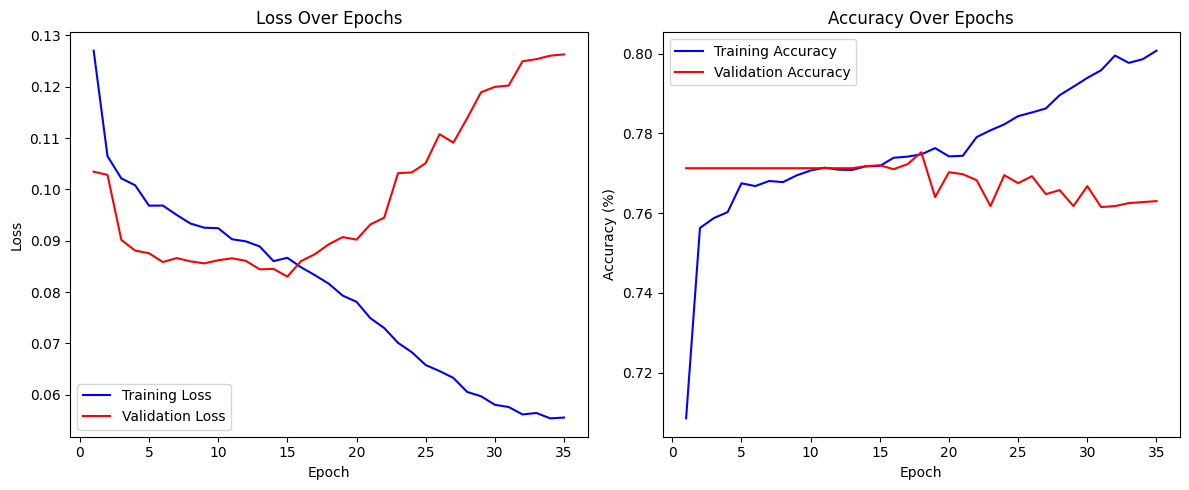

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_history, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'r', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Testing and Results

In [ ]:
model.eval()

test_loss = 0.0
test_acc = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # forward pass
        logits = model(input_ids, attention_mask)

        # compute loss
        loss = criterion(logits, labels)
        test_loss += loss.item()

        # compute accuracy (custom function)
        test_acc += multi_label_accuracy(logits, labels)

        # store predictions and labels
        probs = torch.sigmoid(logits)
        all_preds.append(probs.cpu())
        all_labels.append(labels.cpu())

# compute average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader)

# concatenate all predictions and labels
preds = torch.cat(all_preds, dim=0).numpy()
labels = torch.cat(all_labels, dim=0).numpy()

# binarize predictions
binary_preds = (preds > 0.5).astype(int)

# calculate Micro F1 Score
macro_f1 = f1_score(labels, binary_preds, average='macro')

# print results
print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {avg_test_acc:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

  0%|          | 0/13 [00:00<?, ?it/s]


Test Loss: 0.1305
Test Accuracy: 0.7563
Macro F1 Score: 0.1201


In [ ]:
def evaluate_detailed(model, test_loader, criterion, device, multi_label_accuracy, label_names=None):
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            loss = criterion(logits, labels)
            test_loss += loss.item()

            test_acc += multi_label_accuracy(logits, labels)

            all_preds.append(torch.sigmoid(logits).cpu())
            all_labels.append(labels.cpu())

    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader)

    preds = torch.cat(all_preds, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()

    binary_preds = (preds > 0.38).astype(int)

    micro_f1 = f1_score(labels, binary_preds, average='micro')

    macro_f1 = f1_score(labels, binary_preds, average='macro')

    num_classes = labels.shape[1]
    f1_per_class = []
    for i in range(num_classes):
        f1 = f1_score(labels[:, i], binary_preds[:, i])
        f1_per_class.append(f1)

    print(f"\nTest Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_acc:.4f}")
    print(f"Micro F1 Score: {micro_f1:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print("\nF1 Score per class:")
    if label_names is not None and len(label_names) == num_classes:
        for i, f1 in enumerate(f1_per_class):
            print(f"- {label_names[i]}: {f1:.4f}")
    else:
        for i, f1 in enumerate(f1_per_class):
            print(f"- Class {i}: {f1:.4f}")

    return avg_test_loss, avg_test_acc, micro_f1, macro_f1, f1_per_class

label_names_list = ['gender', 'age', 'appearance', 'individual/group', 'cleanness'] # Example
avg_loss, avg_acc, micro_f1, macro_f1, class_f1s = evaluate_detailed(model, test_loader, criterion.to(device), device, multi_label_accuracy, label_names=label_names_list)
print("\nPer-class F1 Scores:", class_f1s)

# Inference

In [ ]:
def data_processing(predict_sentence):
    """
    입력 문장을 토크나이즈하고 모델 입력 형식으로 변환합니다.
    """
    encoding = tokenizer(
        predict_sentence,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].squeeze(0),        # [seq_len]
        'attention_mask': encoding['attention_mask'].squeeze(0),  # [seq_len]
    }


def predict(predict_sentence):
    """
    문장을 받아서 모델을 통해 예측된 다중 라벨 출력을 반환하고 출력합니다.
    """
    model.eval()
    test_data = data_processing(predict_sentence)

    input_ids = test_data['input_ids'].unsqueeze(0).to(device)        # [1, seq_len]
    attention_mask = test_data['attention_mask'].unsqueeze(0).to(device)  # [1, seq_len]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)  # [1, 5] 로짓

        probs = torch.sigmoid(outputs)  # 확률로 변환
        preds = (probs > 0.330).int()     # threshold 적용

    print(f"Raw Probabilities: {probs.cpu().numpy().flatten()}")
    print(f"Predicted Labels (binary): {preds.cpu().numpy().flatten()}")
    print()


# ---------------------------------------------------------------------------
# 입력 반복
while True:
    sentence = input("하고싶은 말을 입력해주세요 (종료하려면 0 입력): ")
    if sentence.strip() == "0":
        break
    predict(sentence)

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 30대 아줌마들;; 고만들 하세요;
Raw Probabilities: [0.6712736  0.9673054  0.31478027 0.2538382  0.09162089]
Predicted Labels (binary): [1 1 0 0 0]

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 가부장제 한남은 도태가 답이지
Raw Probabilities: [0.22408293 0.05490986 0.13388899 0.3245037  0.3784226 ]
Predicted Labels (binary): [0 0 0 0 1]

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 그냥 이모같은데? 아줌마스러벙
Raw Probabilities: [0.5632297  0.91893506 0.44380695 0.274562   0.08856866]
Predicted Labels (binary): [1 1 1 0 0]

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 똑같이 늙은여자 안팔림
Raw Probabilities: [0.64924824 0.94541335 0.40897223 0.3036616  0.08956116]
Predicted Labels (binary): [1 1 1 0 0]

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 머스마 인상이 않좋네
Raw Probabilities: [0.24644546 0.07571952 0.19883285 0.36090428 0.34770638]
Predicted Labels (binary): [0 0 0 1 1]

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 못생겨서 별로다
Raw Probabilities: [0.15878499 0.20493713 0.31799102 0.4926153  0.20674285]
Predicted Labels (binary): [0 0 0 1 0]

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 문소리 거품아니냐??출연

In [ ]:
label_names = ["gender", "age", "appearance", "individual/group", "cleanness"]

def data_processing(predict_sentence):
    """
    입력 문장을 토크나이즈하고 모델 입력 형식으로 변환합니다.
    """
    encoding = tokenizer(
        predict_sentence,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].squeeze(0),        # [seq_len]
        'attention_mask': encoding['attention_mask'].squeeze(0),  # [seq_len]
    }


def predict(predict_sentence):
    """
    문장을 받아서 모델을 통해 예측된 다중 라벨 출력을 반환하고 출력합니다.
    """
    model.eval()
    test_data = data_processing(predict_sentence)

    input_ids = test_data['input_ids'].unsqueeze(0).to(device)        # [1, seq_len]
    attention_mask = test_data['attention_mask'].unsqueeze(0).to(device)  # [1, seq_len]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)  # [1, 5] 로짓

        probs = torch.sigmoid(outputs)  # 확률로 변환
        preds = (probs > 0.330).int()     # threshold 적용

    print(f"\nRaw Probabilities: {probs.cpu().numpy().flatten()}")
    print("Predicted Labels:")

    for name, pred, prob in zip(label_names, preds[0], probs[0]):
        status = "✅ YES" if pred.item() == 1 else "❌ NO"
        print(f"  - {name:10s}: {status} (p={prob.item():.3f})")
    print()

# ---------------------------------------------------------------------------
# 입력 반복
while True:
    sentence = input("하고싶은 말을 입력해주세요 (종료하려면 0 입력): ")
    if sentence.strip() == "0":
        break
    predict(sentence)

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 30대 아줌마들;; 고만들 하세요;

Raw Probabilities: [0.6712736  0.9673054  0.31478027 0.2538382  0.09162089]
Predicted Labels:
  - gender    : ✅ YES (p=0.671)
  - age       : ✅ YES (p=0.967)
  - appearance: ❌ NO (p=0.315)
  - individual/group: ❌ NO (p=0.254)
  - cleanness : ❌ NO (p=0.092)

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 가부장제 한남은 도태가 답이지

Raw Probabilities: [0.22408293 0.05490986 0.13388899 0.3245037  0.3784226 ]
Predicted Labels:
  - gender    : ❌ NO (p=0.224)
  - age       : ❌ NO (p=0.055)
  - appearance: ❌ NO (p=0.134)
  - individual/group: ❌ NO (p=0.325)
  - cleanness : ✅ YES (p=0.378)

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 그냥 이모같은데? 아줌마스러벙

Raw Probabilities: [0.5632297  0.91893506 0.44380695 0.274562   0.08856866]
Predicted Labels:
  - gender    : ✅ YES (p=0.563)
  - age       : ✅ YES (p=0.919)
  - appearance: ✅ YES (p=0.444)
  - individual/group: ❌ NO (p=0.275)
  - cleanness : ❌ NO (p=0.089)

하고싶은 말을 입력해주세요 (종료하려면 0 입력): 똑같이 늙은여자 안팔림

Raw Probabilities: [0.64924824 0.945413